In [1]:
import sys
sys.path.append('../Scripts')
from capstone_functions import *

In [2]:
from collections import defaultdict

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")
colorblind_palette = sns.color_palette('colorblind').as_hex()

%matplotlib inline

In [3]:
# source : https://blog.jsalv.com/pythonin-voronoi-and-k-means/

# functions to run through k_means algorithm and plot the voronoi

def classify_points(centers, data):
    """Classifies points from data according to which center they're closest to.
       Returns points like {'g': np.array([..., ...], ...), }
    """
    classes = defaultdict(list)
    for pt in data:
        dists = [euclidean(pt, center) for center in centers]
        classes[colorblind_palette[dists.index(min(dists))]].append(pt)

    # Concat the list of points in each class together to a np array.
    classes = {cl: np.array(classes[cl]) for cl in classes.keys()}
    return classes


def find_new_centers(data_classified):
    """Calculates new centers given the classified data."""
    new_means = []
    for pts in data_classified.values():
        new_means.append(pts.mean(axis=0))
    return np.array(new_means)


def plot_voronoi(ax, title, centers, data_classified):
    """Plot the Voronoi diagram with our data classified."""
    ax.set_title(title)
    vor = Voronoi(centers)
    _ = voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False)
    for center in data_classified.keys():
        ax.scatter(
            data_classified[center][:, 0], data_classified[center][:, 1], c=center, s=10
        )
    ax.scatter(centers[:, 0], centers[:, 1], c="black", s=75, marker="*")

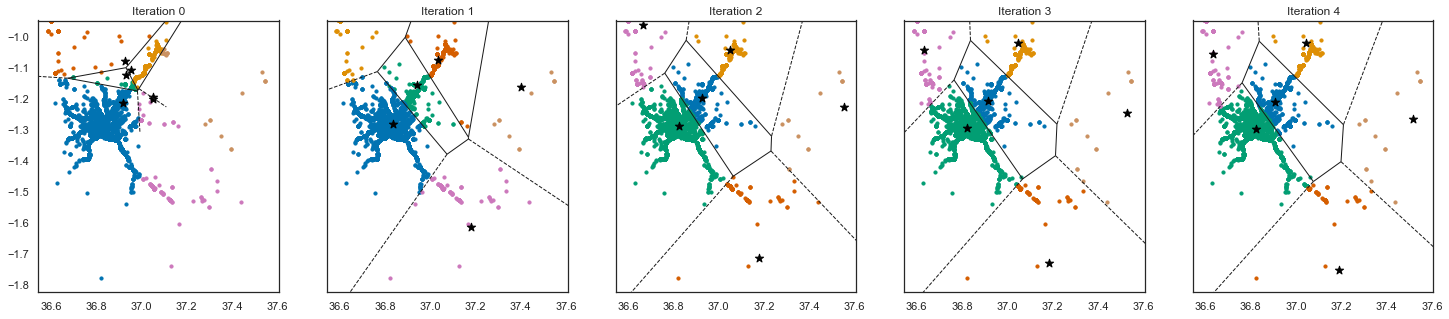

In [20]:
# Create a Subplot grid of the k_means iterations

# load data
train_df = create_crash_df()
# get the lat lon points
data = train_df[['longitude','latitude']].values

# set up initial centroids
n_centers = 6
centroids = np.random.uniform(size=(n_centers, 2))*.2
centroids = centroids + (train_df.longitude.mean(), train_df.latitude.mean())

# set up subplots, cols for each iteration
rows = 1
cols = 5
n_iter = rows * cols
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(25, 5), sharex=True, sharey=True)

# run through iterations of k_means
for i in range(n_iter):
    # call function for assigning points to centroids
    data_classified = classify_points(centers=centroids, data=data)
    # plot the voronoi lines between centroids
    plot_voronoi(ax[i], f"Iteration {i}", centroids, data_classified)
    # save the chart of the iterations
    plt.savefig('../Images/'+f'x_k_means_iter{i:03}.png')
    # update the centroids based on points
    centroids = find_new_centers(data_classified)

In [25]:
print(x_lims)
print(y_lims)

(36.332201603768, 37.8794900011581)
(-3.05000000215335, -0.565402313796744)


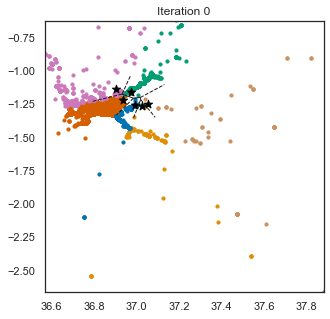

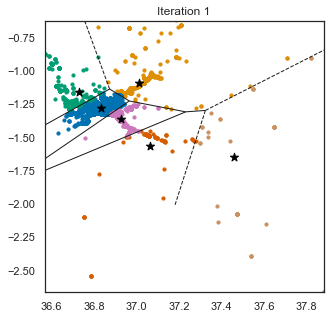

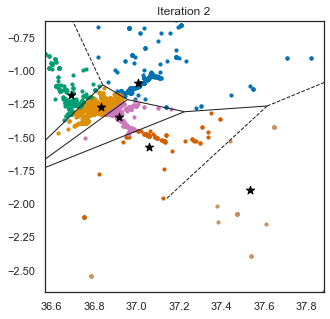

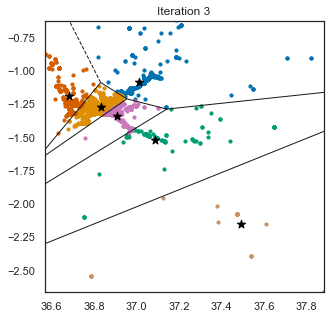

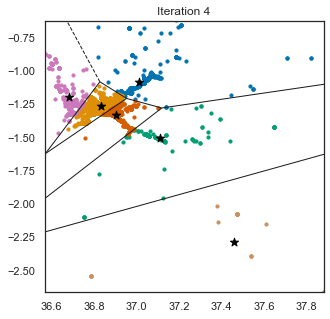

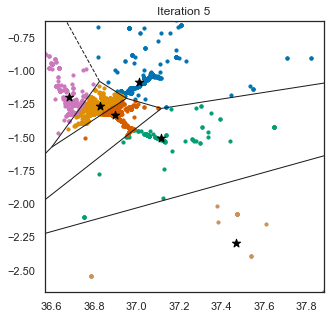

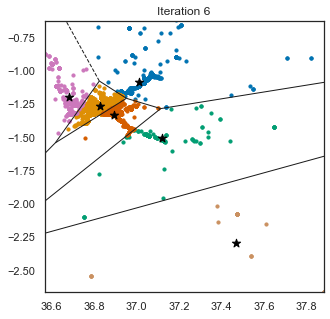

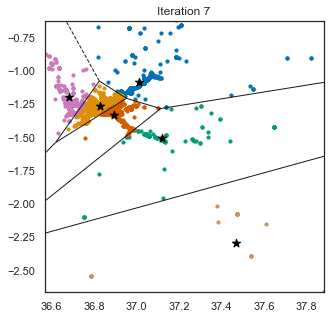

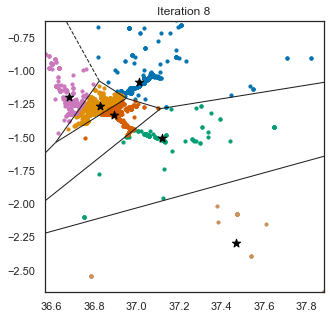

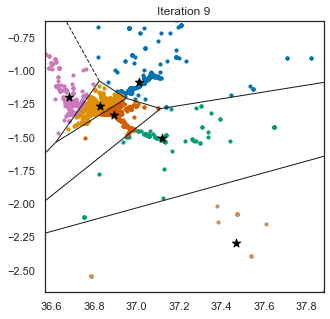

In [48]:
# Create individual plots of k_means iterations for making a gif

# load data
train_df = create_crash_df()
# get the lat lon points
data = train_df[['longitude','latitude']].values

# set up initial centroids
n_centers = 6
centroids = np.random.uniform(size=(n_centers, 2))*.2
centroids = centroids + (train_df.longitude.mean(), train_df.latitude.mean())

# set up subplots, cols for each iteration
n_iter = 10
outlier_filter = .0005
x_lims = (train_df.longitude.quantile(outlier_filter), train_df.longitude.quantile(1-outlier_filter))
y_lims = (train_df.latitude.quantile(outlier_filter), train_df.latitude.quantile(1-outlier_filter))


# run through iterations of k_means
for i in range(n_iter):
    # call function for assigning points to centroids
    data_classified = classify_points(centers=centroids, data=data)
    # plot the voronoi lines between centroids
    fig, ax = plt.subplots(figsize=(5, 5), sharex=True, sharey=True)
    plot_voronoi(ax, f"Iteration {i}", centroids, data_classified)
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)

    # save the chart of the iterations
    plt.savefig('../Images/'+f'Z_k_means_iter{i:03}.png')
    # update the centroids based on points
    centroids = find_new_centers(data_classified)

In [49]:
# create animated gif

import imageio
import os
images_path = '../Images'
files = os.listdir(images_path)
files.sort()
# assume that your images that you 
# want to make the GIF are under the my_images folder
images_path_filename = [os.path.join(images_path,file) for file in files]
# fps are the frames per second
images = []
for img in images_path_filename:
    images.append(imageio.imread(img))
imageio.mimsave('../Outputs/k_means.gif', images, fps=3)